# Image_Proccess

## 1. Preprocess

### Import pkgs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler, Binarizer
from sklearn.metrics import log_loss, accuracy_score
from IPython.display import display
import skimage
%matplotlib inline

In [2]:
import os
import time
import zipfile
import lzma
import pickle
from PIL import Image
from shutil import copy2
import cv2

### Run name

In [3]:
project_name = 'SC_Iceberg_Classifier'
step_name = 'Image_Proccess'
date_str = time.strftime("%Y%m%d", time.localtime())
time_str = time.strftime("%Y%m%d_%H%M%S", time.localtime())
run_name = project_name + '_' + step_name + '_' + time_str
print('run_name: ' + run_name)
t0 = time.time()

run_name: SC_Iceberg_Classifier_Image_Proccess_20180106_094430


### Basic folders

In [4]:
cwd = os.getcwd()
input_path = os.path.join(cwd, 'input')
log_path = os.path.join(cwd, 'log')
model_path = os.path.join(cwd, 'model')
output_path = os.path.join(cwd, 'output')
print('input_path: ' + input_path)
print('log_path: ' + log_path)
print('model_path: ' + model_path)
print('output_path: ' + output_path)

input_path: /data1/Kaggle/statoil-iceberg-classifier-challenge/input
log_path: /data1/Kaggle/statoil-iceberg-classifier-challenge/log
model_path: /data1/Kaggle/statoil-iceberg-classifier-challenge/model
output_path: /data1/Kaggle/statoil-iceberg-classifier-challenge/output


### Basic functions

In [5]:
import sys
def describe(arr):
    print(arr.shape, arr.min(), arr.max(), sys.getsizeof(arr))

In [6]:
def show_data_images(rows, fig_column, id_data, y_data, *args):
    columns = len(args)
    figs, axes = plt.subplots(rows, columns, figsize=(rows, fig_column*columns))
    print(axes.shape)  
    for i, ax in enumerate(axes):
        y_data_str = ''
        if type(y_data) != type(None):
            y_data_str =  '_' + str(y_data[i])
        ax[0].set_title(id_data[i] + y_data_str)
        for j, arg in enumerate(args):
            ax[j].imshow(arg[i])

### Unzip files

We need unzip file manually with 7z installed.

### Load data

In [7]:
sample_submission_path = os.path.join(input_path, 'sample_submission.csv')
sample_submission = pd.read_csv(sample_submission_path)
print(sample_submission.shape)
sample_submission.head(2)

(8424, 2)


,id,is_iceberg
0,5941774d,0.5
1,4023181e,0.5


In [8]:
%%time
#Load data
data_path = os.path.join(input_path, 'train.json')
test_path = os.path.join(input_path, 'test.json')
pd_data = pd.read_json(data_path)
pd_test = pd.read_json(test_path)
print(pd_data.shape)
print(pd_test.shape)
print(pd_data.columns)
print(pd_test.columns)

(1604, 5)
(8424, 4)
Index(['band_1', 'band_2', 'id', 'inc_angle', 'is_iceberg'], dtype='object')
Index(['band_1', 'band_2', 'id', 'inc_angle'], dtype='object')
CPU times: user 8.62 s, sys: 3.68 s, total: 12.3 s
Wall time: 12.3 s


In [9]:
id_data = pd_data['id'].as_matrix()
id_test = pd_test['id'].as_matrix()
describe(id_data)
describe(id_test)

id_data_path = os.path.join(input_path, 'id_data.p')
id_test_path = os.path.join(input_path, 'id_test.p')
pickle.dump(id_data, open(id_data_path, 'wb'))
pickle.dump(id_test, open(id_test_path, 'wb'))

(1604,) 000d71b1 fffe76e4 96
(8424,) 000c65d7 fff77564 96


In [10]:
is_iceberg = pd_data['is_iceberg']
describe(is_iceberg)

y_data = is_iceberg

is_iceberg_path = os.path.join(input_path, 'is_iceberg.p')
pickle.dump(is_iceberg, open(is_iceberg_path, 'wb'))

(1604,) 0 1 25688


In [11]:
inc_angle_data = pd_data['inc_angle'].replace('na', 0).astype(float).fillna(0.0)
inc_angle_test = pd_test['inc_angle'].replace('na', 0).astype(float).fillna(0.0)

describe(inc_angle_data)
describe(inc_angle_test)

inc_angle_data_path = os.path.join(input_path, 'inc_angle_data.p')
inc_angle_test_path = os.path.join(input_path, 'inc_angle_test.p')

pickle.dump(inc_angle_data, open(inc_angle_data_path, 'wb'))
pickle.dump(inc_angle_test, open(inc_angle_test_path, 'wb'))

(1604,) 0.0 45.9375 25688
(8424,) 23.0805 50.66178518 134808


In [12]:
#get numpy arrays for train/test data
band1 = pd_data['band_1'].values
im1 = np.zeros((len(band1),len(band1[0])))
for i, band in enumerate(band1):
    im1[i,:]=np.asarray(band)
    
band2 = pd_data['band_2'].values
im2 = np.zeros((len(band2),len(band2[0])))
for i, band in enumerate(band2):
    im2[i,:]=np.asarray(band)


#get numpy array for test data
band1_t = pd_test['band_1'].values
im1_test = np.zeros((len(band1_t),len(band1_t[0])))
for i, band in enumerate(band1_t):
    im1_test[i,:]=np.asarray(band)
    
band2_t = pd_test['band_2'].values
im2_test = np.zeros((len(band2_t),len(band2_t[0])))
for i, band in enumerate(band2_t):
    im2_test[i,:]=np.asarray(band)

In [13]:
band1_data = im1.reshape(-1, 75,75)
band2_data = im2.reshape(-1, 75,75)

band1_test = im1_test.reshape(-1, 75,75)
band2_test = im2_test.reshape(-1, 75,75)

describe(band1_data)
describe(band2_data)
describe(band1_test)
describe(band2_test)

band1_data_path = os.path.join(input_path, 'band1_data.p')
band2_data_path = os.path.join(input_path, 'band2_data.p')
band1_test_path = os.path.join(input_path, 'band1_test.p')
band2_test_path = os.path.join(input_path, 'band2_test.p')

pickle.dump(band1_data, open(band1_data_path, 'wb'))
pickle.dump(band2_data, open(band2_data_path, 'wb'))
pickle.dump(band1_test, open(band1_test_path, 'wb'))
pickle.dump(band2_test, open(band2_test_path, 'wb'))

x_data = pickle.load(open(band1_data_path, mode='rb'))

(1604, 75, 75) -45.594448 34.574917 128
(1604, 75, 75) -45.655499 20.154249 128
(8424, 75, 75) -45.6805458069 37.090523 128
(8424, 75, 75) -49.0835 37.0905227661 128


(5, 2)


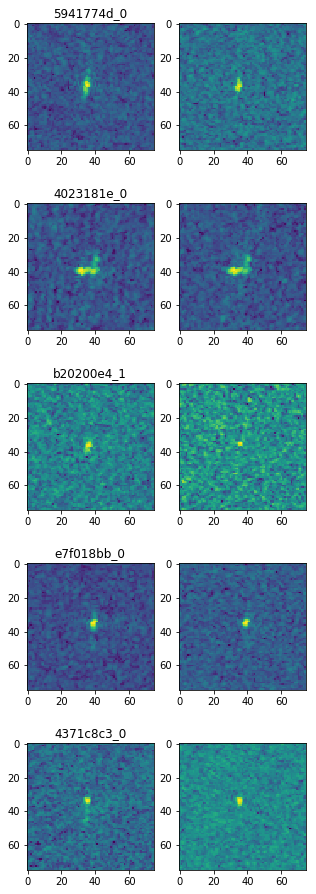

In [14]:
show_data_images(5, 8, id_test, y_data, band1_data, band2_data)

(5, 2)


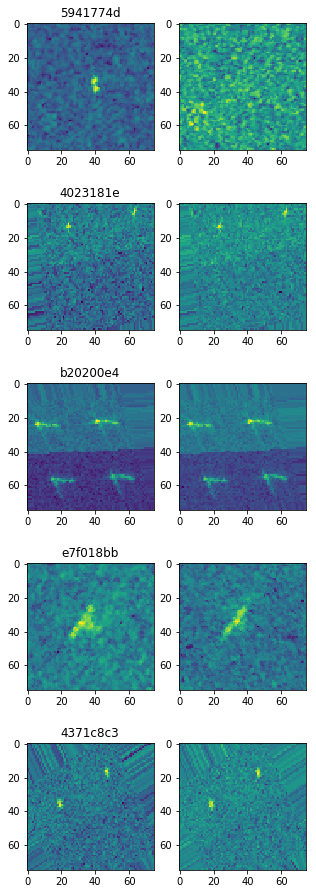

In [15]:
show_data_images(5, 8, id_test, None, band1_test, band2_test)

In [16]:
t1 = time.time()
print('time cost: %.2f s' % (t1-t0))
print('Done!')

time cost: 28.25 s
Done!


In [17]:
print(run_name)

SC_Iceberg_Classifier_Image_Proccess_20180106_094430
